In [213]:
import sys
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import joblib as jb

#Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Modeling
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LSTM, GRU, Input
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

np.set_printoptions(threshold=20)

#### Importing stock prices data and cleaning date

In [2]:
prices_df = pd.read_csv('./prices.csv')
prices_df['clean_date'] = pd.to_datetime(prices_df.date, format='%Y-%m-%d %H:%M:%S')
prices_df.drop('date', axis=1, inplace=True)
prices_df.head()

,symbol,open,close,low,high,volume,clean_date
0,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2016-01-05
1,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,2016-01-06
2,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,2016-01-07
3,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,2016-01-08
4,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,2016-01-11


#### Selecting Apple stock to build model

In [3]:
apple_df = prices_df[prices_df['symbol'] == 'AAPL'].copy()
apple_df.reset_index(drop=True, inplace=True)
aapl_close_df = apple_df[['clean_date', 'close']].copy()

#### Splitting between training (train) and validation (val) data (~70%-30%)

In [8]:
data_size = aapl_close_df['clean_date'].shape[0]
print("Train size: {}\nVal size: {}".format(round(0.7*data_size), round(0.3*data_size)))

Train size: 1233
Val size: 529


In [9]:
train_mask = aapl_close_df['clean_date'] < "2015-01-01"
val_mask = aapl_close_df['clean_date'] >= "2015-01-01"

train_df, val_df = aapl_close_df[train_mask].copy(), aapl_close_df[val_mask].copy()
print(train_df.shape, val_df.shape)

(1258, 2) (504, 2)


In [6]:
train_df.head()

,clean_date,close
0,2010-01-04,214.009998
1,2010-01-05,214.379993
2,2010-01-06,210.969995
3,2010-01-07,210.580000
4,2010-01-08,211.980005


#### Scaling close price: fit_transform train data, transform val data

In [10]:
# train
train = train_df['close'].to_numpy()
scaler = StandardScaler()
train = scaler.fit_transform(train.reshape(-1,1))

# val
val = val_df['close'].to_numpy()
val = scaler.transform(val.reshape(-1,1))

print(train.shape)

(1258, 1)


#### Determining function to process lag features

In [85]:
def process_lag_features(data, n_lags):
    X_data, y_data = [], []
    feature_size = len(data) - n_lags
    
    for n in range(feature_size):
        aux = data[n:(n + n_lags), 0]
        X_data.append(aux)
        y_data.append(data[(n + n_lags), 0])
   
    return np.array(X_data), np.array(y_data)

#### Determining function to process rolling mean feature

In [86]:
def process_roll_mean_feature(data, window, min_periods):
    X_data = pd.DataFrame(data)
    X_data = X_data.rolling(window=window, min_periods=min_periods).mean().values
    
    return np.array(X_data)

#### Setting feature engineering parameters

In [195]:
n_lags = 4 # number of past values used for predicting next one
window = 10 # size of window used to compute rolling mean
min_periods = 3 # minimum number of past values available needed for computting rolling mean

#### Computing features

In [196]:
# train
# lag
X_lag_train, y_train_raw = process_lag_features(train, n_lags)
X_lag_train_final = X_lag_train[min_periods-1:].copy()

# rolling mean
X_roll_train = process_roll_mean_feature(train, window=window, min_periods=min_periods)
X_roll_train_final = X_roll_train[min_periods-1:-n_lags].copy()

# assemblying X_train
X_train = np.concatenate((X_lag_train_final, X_roll_train_final),axis=1)

In [ ]:
# valid
# lag
X_lag_val, y_val_raw = process_lag_features(val, n_lags)
X_lag_val_final = X_lag_val[min_periods-1:].copy()

# rolling mean
X_roll_val = process_roll_mean_feature(val, window=window, min_periods=min_periods)
X_roll_val_final = X_roll_val[min_periods-1:-n_lags].copy()

# assemblying X_val
X_val = np.concatenate((X_lag_val_final, X_roll_val_final),axis=1)

In [ ]:
# y
y_train = y_train_raw[min_periods-1:].copy()
y_val = y_val_raw[min_periods-1:].copy()

In [197]:
X_train.shape, y_train.shape

((1252, 5), (1252,))

In [198]:
X_val.shape, y_val.shape

((498, 5), (498,))

#### Reshaping for required NN input

In [199]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0] , 1, X_val.shape[1])

In [200]:
X_train, X_train.shape

(array([[[-1.14499634, -1.14744547, -1.13865356, -1.15039702,
          -1.13149451]],
 
        [[-1.14744547, -1.13865356, -1.15039702, -1.16540603,
          -1.13548225]],
 
        [[-1.13865356, -1.15039702, -1.16540603, -1.14700587,
          -1.13611651]],
 
        ...,
 
        [[-1.76061656, -1.76312853, -1.76645688, -1.75402267,
          -1.77331456]],
 
        [[-1.76312853, -1.76645688, -1.75402267, -1.75452503,
          -1.77430678]],
 
        [[-1.76645688, -1.75402267, -1.75452503, -1.76325416,
          -1.7742691 ]]]),
 (1252, 1, 5))

#### Modeling

In [201]:
model = Sequential()
model.add(GRU(256, input_shape=(1,n_lags+1), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 1, 256)            201984    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 743,809
Trainable params: 743,809
Non-trainable params: 0
________________________________________________

In [202]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Train on 1252 samples, validate on 498 samples
Epoch 1/100
1252/1252 [==============================] - 5s 4ms/sample - loss: 0.8135 - mean_squared_error: 0.8135 - val_loss: 1.7133 - val_mean_squared_error: 1.7133
Epoch 2/100
1252/1252 [==============================] - 0s 168us/sample - loss: 0.3099 - mean_squared_error: 0.3099 - val_loss: 0.1060 - val_mean_squared_error: 0.1060
Epoch 3/100
1252/1252 [==============================] - 0s 173us/sample - loss: 0.0663 - mean_squared_error: 0.0663 - val_loss: 0.1566 - val_mean_squared_error: 0.1566
Epoch 4/100
1252/1252 [==============================] - 0s 186us/sample - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0231 - val_mean_squared_error: 0.0231
Epoch 5/100
1252/1252 [==============================] - 0s 178us/sample - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 6/100
1252/1252 [==============================] - 0s 197us/sample - loss: 0.0356 - mean_squared_error: 

#### Plotting train and val errors through training

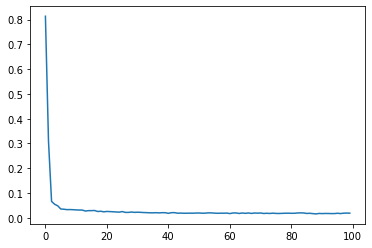

In [203]:
plt.plot(model.history.history['mean_squared_error'])

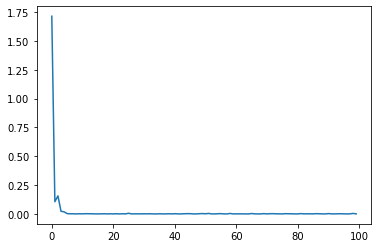

In [204]:
plt.plot(model.history.history['val_mean_squared_error'])

In [205]:
train_score = model.evaluate(X_train, y_train, verbose=1)
val_score = model.evaluate(X_val, y_val, verbose=1)

498/498 [==============================] - 0s 131us/sample - loss: 6.2112e-04 - mean_squared_error: 6.2112e-04


#### Plotting predicted X actual validation prices

In [206]:
pred = model.predict(X_val)
pred = scaler.inverse_transform(pred)
y_val = y_val.reshape(y_val.shape[0], 1)
y_val_inv_trans = scaler.inverse_transform(y_val)

Red: Predicted Stock Prices
Blue: Actual Stock Prices



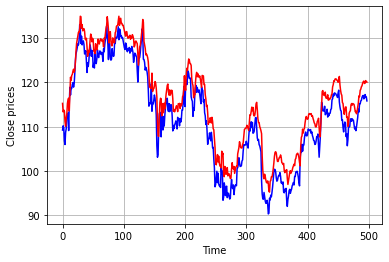

In [207]:
print("Red: Predicted Stock Prices\nBlue: Actual Stock Prices\n")
#b: blue line, actual
plt.plot(y_val_inv_trans, 'b')
#r: red line, predicted
plt.plot(pred, 'r')
plt.xlabel('Time')
plt.ylabel('Close prices')
plt.grid(True)
plt.show()

#### Exporting scaler and model

In [ ]:
jb.dump(scaler, "./scaler.pkl.z")

In [209]:
model.save("model.h5")